
# **Text Suicide Detection by Fine-tuning a Pre-trained Model Using Keras API**

In the modern age of technology, the ubiquity of textual data has presented an opportunity to gain insights into individuals' mental health. With the alarming rise in suicide rates worldwide, the early detection of suicidal tendencies in written text can be a lifesaver. This project aims to harness the power of advanced natural language processing techniques to address this challenge.

Building a model from scratch for such a nuanced task can be resource-intensive and may not achieve the desired accuracy. Instead, leveraging the strengths of pre-trained models like BERT, which have already learned rich language representations from extensive textual data, can be more effective. However, direct application of these models may not yield satisfactory results as they might not have been trained on context-specific data related to mental health or suicide.

Therefore, in this endeavor, we fine-tuned the BERT-base model using the Keras API to specialize it for suicide detection. Fine-tuning involves training the pre-existing model on our specific dataset, allowing it to adjust and refine its weights to our context, while retaining the powerful language understanding capabilities it acquired during its initial training.

By leveraging the Keras API, the project streamlined the training process, integrating seamlessly with TensorFlow's backend. This ensures that the fine-tuning process remains intuitive, scalable, and highly efficient.

After the fine-tuning process, the model demonstrated its potential in detecting suicidal inclinations from textual data. However, while initial results are promising, it's essential to remember that this model is not yet ready for real-world scenarios. It serves as a foundation upon which further refinements can be made, and additional datasets can be integrated.

To ensure the continuity and iterative improvement of this project, all resources, including the trained model and training history, have been saved. This will allow for easy resumption of training, further fine-tuning, or evaluation using newer data in the future.

In conclusion, this project underscores the significance of adapting state-of-the-art models to specific challenges. With continued refinements, it holds the promise of becoming a valuable tool in mental health assessments, potentially saving lives by providing timely interventions.



In [76]:
from google.colab import files
files.upload()  # This will prompt you to upload a file. Choose the kaggle.json file.

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"hannabawardi","key":"386e3efc661ef5d0b081f0cdb0d22d83"}'}

In [77]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [78]:
!pip install kaggle

In [79]:
!kaggle datasets download -d nikhileswarkomati/suicide-watch

suicide-watch.zip: Skipping, found more recently modified local copy (use --force to force download)


In [80]:
!unzip /content/suicide-watch.zip

Archive:  /content/suicide-watch.zip
replace Suicide_Detection.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Suicide_Detection.csv   


In [81]:
!pip install emoji

In [82]:
!pip install neattext

In [83]:
!pip install wordcloud

In [84]:
!pip install transformers

In [85]:
!pip install datasets

In [86]:
# ------------------------------------------------------------------------------
# Text processing libraries
import re # for regular expression use

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
poter_stem = PorterStemmer()

import neattext.functions as nfx
import emoji

import string
punc_list = list(string.punctuation)

import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = list(nlp.Defaults.stop_words)
additional_stop_words = [',', 'im', 'like', 'want', 's', 'ive', 'm', 'feel', 't', ':',
                        'life', 'time', 'work', 'thought', 'famili', 'peopl', 'year',
                        'year', 'friend', 'day', 'dont', '’', ';', 'person', 'month',
                        '&', 'peopl', 'think', 'know', 'people', 'family', 'day', 'time',
                        '2008', '2009', '2010', '2011', '2012', '2013',
                        '2014', '2015', '2016', '2017', '2018', '2019', '2020',
                        '2021', '2022', '2023', 'like', 'know', 'think', 'like', 'karma', 'message', 'massage',
                        'friend', 'year', 'go', 'month', 'week', 'period', 'post', 'months', '.', ':', 'friends', 'things', 'cant', 'don',
                        'girl', 'girls','boys','boy', 'guy', 'mom','dad', 'na']
stop_words += additional_stop_words



# ------------------------------------------------------------------------------
# Libraries for buidlding machine learning models and data manipulation
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertConfig
from tensorflow.keras.layers import Dense
from transformers import BertConfig


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# ------------------------------------------------------------------------------
# Vasiualization libraries

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ------------------------------------------------------------------------------
# Additional libraries

import random
from collections import Counter
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **1.Data Analysis**

In [87]:
data = pd.read_csv('/content/Suicide_Detection.csv')
data.shape

(232074, 3)

In [88]:
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [89]:
for text, label in zip(data['text'][:5],data['class'][:5]):
    print(text,'\n')
    print(label)
    print('-'*100)

Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and lied to me so much that I have decided to refuse to go back to her. As of a few days ago, she began threatening suicide. I have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe I'll come back. I know a lot of people will threaten this in order to get their way, but what happens if she really does? What do I do and how am I supposed to handle her death on my hands? I still love my wife but I cannot deal with getting cheated on again and constantly feeling insecure. I'm worried today may be the day she does it and I hope so much it doesn't happen. 

suicide
----------------------------------------------------------------------------------------------------
Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it 

non-suicide
--------------------

##### **Sampling a subset from our data**
At first we will take and explore 10000 records from our data value to save resources



In [90]:
subset_df = data.sample(n=50000, random_state=42).reset_index()
subset_df = subset_df.drop(['index', 'Unnamed: 0'], axis=1)
subset_df

,text,class
0,I Don't know?7? Months self harm free and the ...,suicide
1,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
2,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
3,I've honestly got no idea what to do anymore.I...,suicide
4,Do you ever just cry? Like you just think abou...,non-suicide
...,...,...
49995,okay say whatever you want BUT what is wrong w...,non-suicide
49996,one more stop til school yay,non-suicide
49997,Yo I found an amazing routine. Master of batio...,non-suicide
49998,FUCKKKKK more texts more texts more texts My b...,non-suicide


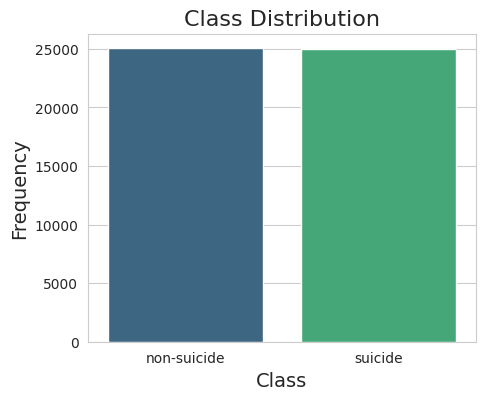

non-suicide    25046
suicide        24954
Name: class, dtype: int64


In [91]:
# Set overall aesthetic style
sns.set_style("whitegrid")

# Set the size of the plot
plt.figure(figsize=(5,4))

# Create the countplot with specific order and palette
sns.countplot(x=subset_df['class'], order=subset_df['class'].value_counts().index, palette='viridis')

# Set the title and labels
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display the plot
plt.show()
print(subset_df['class'].value_counts())

In [92]:
indecies = [random.randint(0, 9999) for _ in range(10)]

for index in indecies:
    print(subset_df.iloc[index]['text'])
    print()
    print(subset_df.iloc[index]['class'])
    print("-"*100)

Someone, please take care of my animals.3 cats (2 that are &lt;1 year: and one that Reddit saved, you guys are awesome), an 18 yr old cat, and a 3 year old Chiweenie. I cannot continue like this but they are the most important things in my life. They need love. They deserve love.m

I understand what my passing will put them through and I am truly sorry for that, but I cannot continue with this life.  

Fuck worker's comp, fuck my friends that say I've changed because of my injury.

I didn't ask for this but these were cards I was dealt.

I'm sorry for not being stronger. I feel so much shame but after 6 years of this, something that was not my fault, I cannot find it in me to go on.  I have been decimated by the CA worker's comp system. I lost everything and I don't,  I can't continue.

It's been 1.5 years since I've seen a comp doctor. I suffer from PTSD, severe depression and severe anxiety.  

I am a shell of the person I used to be.  

I've lost everything and I have nothing at 33 



### **Function to Process Given Text**

We will perform the following text preprocessing steps:
- Case folding (converting to lowercase)
- Removing noisy characters
- Eliminating URLs and email addresses
- Replacing emojis with their descriptive text
- Applying stemming
- Removing stop words.


In [93]:
def process_text(text):
    """
    - Case folding (converting to lowercase)
    - Removing noisy characters
    - Eliminating URLs and email addresses
    - Replacing emojis with their descriptive text
    - Applying stemming
    - Removing stop words.

    Arguments:
    text (string) -- a text that is given for cleaning

    returns:
    a cleaned and processed text
    """
    text = text.lower() # case folding
    text_new = re.sub(r"['#@\$\"\.,!?~\:\(\)]", "",text) # removing certain characters
    text_new = re.sub(r"[-_/]", " ", text_new) # replacing some characters with sapce
    text_new = re.sub(r" +", " ", text_new)
    text_new = re.sub(r'(.)\1{2,}', r'\1', text_new)
    text_new = nfx.remove_urls(text_new)
    text_new = nfx.remove_emails(text_new)
    text_new = emoji.demojize(text_new) # replacing emojis with explanation text
    text_new = nfx.remove_numbers(text_new)

    tokens = nltk.word_tokenize(text_new) # Spliting the text into words
    tokens = [token for token in tokens if token not in stop_words] # poter_stem.stem(token)

    return " ".join(tokens)

subset_df['cleaned_text'] = subset_df['text'].apply(lambda text : process_text(text))
subset_df

,text,class,cleaned_text
0,I Don't know?7? Months self harm free and the ...,suicide,self harm free urge gets stronger stronger pas...
1,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide,start rich start company afford big van trips ...
2,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide,poem haiku u game dev hi hello hello stop fuck...
3,I've honestly got no idea what to do anymore.I...,suicide,honestly got idea anymoreit feels fake backtal...
4,Do you ever just cry? Like you just think abou...,non-suicide,cry unfair cry cry sit seriously sitting cryin...
...,...,...,...
49995,okay say whatever you want BUT what is wrong w...,non-suicide,okay wrong rules repost memes subreddit find g...
49996,one more stop til school yay,non-suicide,stop til school yay
49997,Yo I found an amazing routine. Master of batio...,non-suicide,yo found amazing routine master bation shower ...
49998,FUCKKKKK more texts more texts more texts My b...,non-suicide,fuck texts texts texts brother found reddit ac...


In [94]:
data_sui_1_vis =  subset_df[subset_df['class'] == "suicide"]
data_sui_0_vis =  subset_df[subset_df['class'] == "non-suicide"]

{'going': 12261, 'help': 9964, 'years': 9896, 'anymore': 8590, 'die': 8131, 'way': 8028, 'fucking': 7575, 'suicide': 7543, 'end': 7483, 'kill': 7436, 'better': 7412, 'live': 7344, 'got': 7205, 'good': 7009, 'school': 6745}


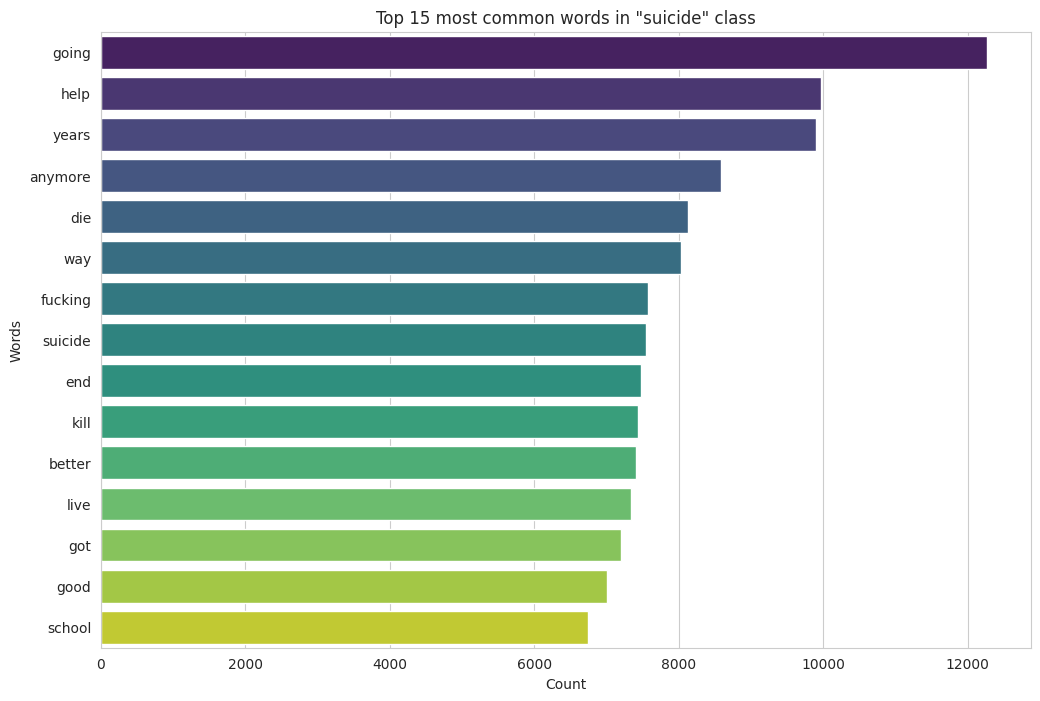

In [95]:
all_text = ' '.join(data_sui_1_vis['cleaned_text'].tolist())
words = nltk.word_tokenize(all_text)

word_freq = Counter(words)
common_words = dict(word_freq.most_common(15))
print(common_words)

# Visualization
plt.figure(figsize=(12,8))
sns.barplot(x=list(common_words.values()), y=list(common_words.keys()), palette="viridis")
plt.title('Top 15 most common words in "suicide" class')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

{'\u200d': 12426, '\u200c': 7789, 'filler': 7397, ':': 5990, '*': 4271, 'gt': 3453, 'got': 3414, 'school': 3178, 'lt': 3174, 'good': 2794, '·': 2473, 'need': 2360, 'said': 2326, 'help': 2266, 'love': 2199}


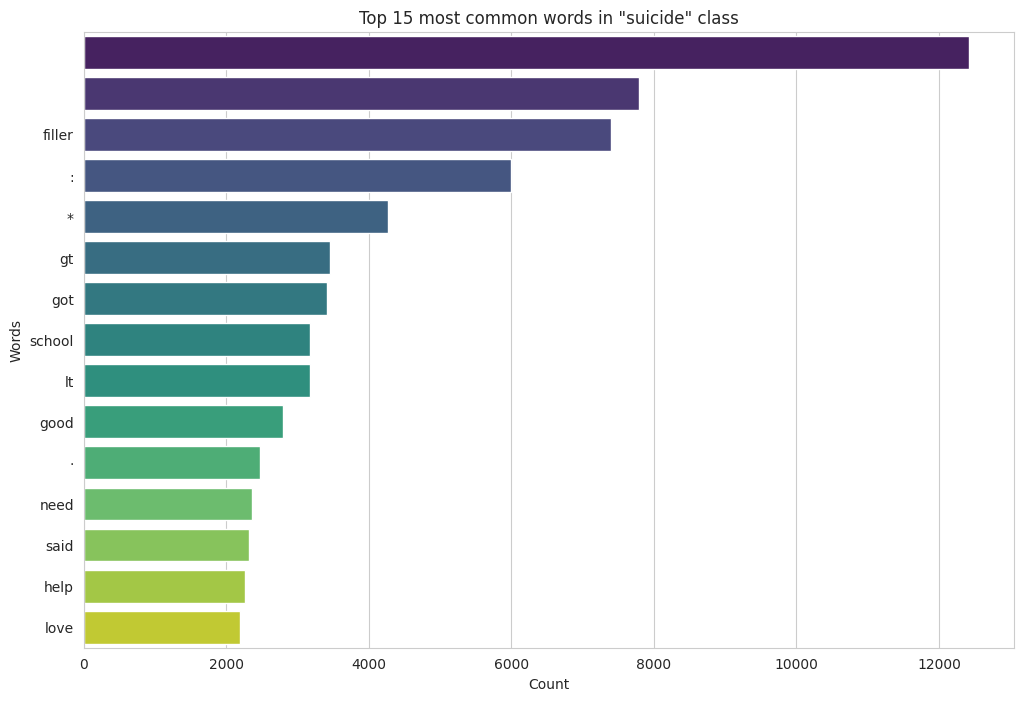

In [96]:
all_text = ' '.join(data_sui_0_vis['cleaned_text'].tolist())
words = nltk.word_tokenize(all_text)

word_freq = Counter(words)
common_words = dict(word_freq.most_common(15))
print(common_words)

# Visualization
plt.figure(figsize=(12,8))
sns.barplot(x=list(common_words.values()), y=list(common_words.keys()), palette="viridis")
plt.title('Top 15 most common words in "suicide" class')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

In the distribution of terms, you can observe the differences between the words most commonly used by people who lost their lives to suicide and those used by people who did not commit suicide. Words like 'killing', 'needing', 'fucking', 'help' have more extreme connotations than those in the second category.

**let's discover some statistical features:**

In [97]:
lens = []

def find_len(text):
    tokens = nltk.word_tokenize(text)
    lens.append(len(tokens))


subset_df['cleaned_text'].apply(lambda text : find_len(text))
len_np = np.array(lens)


print("The average number of words in a sentence in our processed data:", int(np.mean(len_np)))
print("The std of number of words in a sentence in our processed data: ", np.std(len_np))
print("The max number of words in a sentence in our processed data: ", np.max(len_np))
print("The min number of words in a sentence in our processed data: ", np.min(len_np))
print(f"Q1 (25th percentile): {np.percentile(len_np, 25)}")
print(f"Q2 (50th percentile / median): {np.percentile(len_np, 50)}")
print(f"Q3 (75th percentile): {np.percentile(len_np, 75)}")

The average number of words in a sentence in our processed data: 46
The std of number of words in a sentence in our processed data:  93.33704644644376
The max number of words in a sentence in our processed data:  7790
The min number of words in a sentence in our processed data:  0
Q1 (25th percentile): 11.0
Q2 (50th percentile / median): 22.0
Q3 (75th percentile): 52.0


In [98]:
subset_df['Len'] = len_np
subset_df

,text,class,cleaned_text,Len
0,I Don't know?7? Months self harm free and the ...,suicide,self harm free urge gets stronger stronger pas...,59
1,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide,start rich start company afford big van trips ...,11
2,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide,poem haiku u game dev hi hello hello stop fuck...,13
3,I've honestly got no idea what to do anymore.I...,suicide,honestly got idea anymoreit feels fake backtal...,62
4,Do you ever just cry? Like you just think abou...,non-suicide,cry unfair cry cry sit seriously sitting cryin...,12
...,...,...,...,...
49995,okay say whatever you want BUT what is wrong w...,non-suicide,okay wrong rules repost memes subreddit find g...,22
49996,one more stop til school yay,non-suicide,stop til school yay,4
49997,Yo I found an amazing routine. Master of batio...,non-suicide,yo found amazing routine master bation shower ...,12
49998,FUCKKKKK more texts more texts more texts My b...,non-suicide,fuck texts texts texts brother found reddit ac...,16


**Let's clean our data from noisy samples**

In [99]:
Q1 = np.percentile(len_np, 25)
Q3 = np.percentile(len_np, 75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

subset_clean = subset_df[subset_df['Len'] <= upper_bound]
subset_clean = subset_clean[subset_clean['Len'] > 0]

In [100]:
subset_clean

,text,class,cleaned_text,Len
0,I Don't know?7? Months self harm free and the ...,suicide,self harm free urge gets stronger stronger pas...,59
1,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide,start rich start company afford big van trips ...,11
2,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide,poem haiku u game dev hi hello hello stop fuck...,13
3,I've honestly got no idea what to do anymore.I...,suicide,honestly got idea anymoreit feels fake backtal...,62
4,Do you ever just cry? Like you just think abou...,non-suicide,cry unfair cry cry sit seriously sitting cryin...,12
...,...,...,...,...
49995,okay say whatever you want BUT what is wrong w...,non-suicide,okay wrong rules repost memes subreddit find g...,22
49996,one more stop til school yay,non-suicide,stop til school yay,4
49997,Yo I found an amazing routine. Master of batio...,non-suicide,yo found amazing routine master bation shower ...,12
49998,FUCKKKKK more texts more texts more texts My b...,non-suicide,fuck texts texts texts brother found reddit ac...,16


In [101]:
print("The average number of words in a sentence in our processed data:", int(np.mean(subset_clean["Len"])))
print("The std of number of words in a sentence in our processed data: ", np.std(subset_clean["Len"]))
print("The max number of words in a sentence in our processed data: ", np.max(subset_clean["Len"]))
print("The min number of words in a sentence in our processed data: ", np.min(subset_clean["Len"]))
print(f"Q1 (25th percentile): {np.percentile(subset_clean['Len'], 25)}")
print(f"Q2 (50th percentile / median): {np.percentile(subset_clean['Len'], 50)}")
print(f"Q3 (75th percentile): {np.percentile(subset_clean['Len'], 75)}")

The average number of words in a sentence in our processed data: 28
The std of number of words in a sentence in our processed data:  25.60688949520461
The max number of words in a sentence in our processed data:  113
The min number of words in a sentence in our processed data:  1
Q1 (25th percentile): 10.0
Q2 (50th percentile / median): 19.0
Q3 (75th percentile): 40.0


In [102]:
data_sui_1_vis =  subset_clean[subset_clean['class'] == "suicide"]
data_sui_0_vis =  subset_clean[subset_clean['class'] == "non-suicide"]

Before filtering, the average sentence length in the processed data was 46 words, with a wide range from 0 to 6,578 words and a high standard deviation of 104. After filtering, the average sentence length reduced to 28 words, with a tighter range of 1 to 115 words and a significantly lower standard deviation of 25.8.

### **Let's have a look on words cloud**

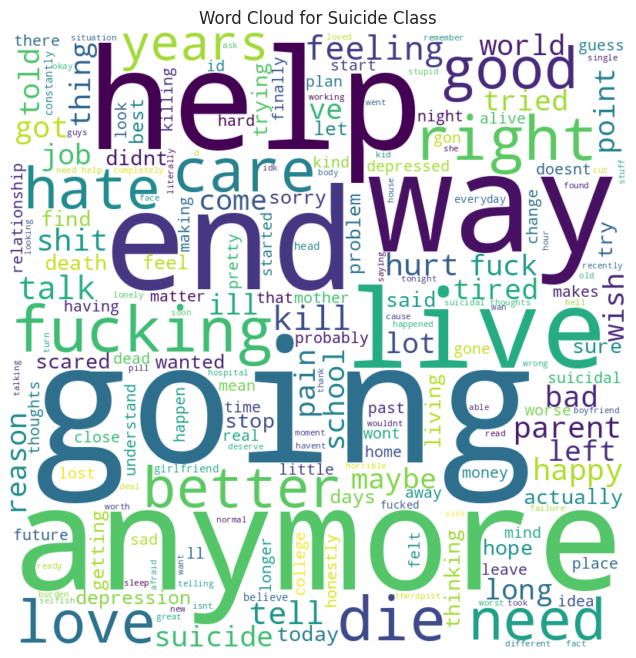

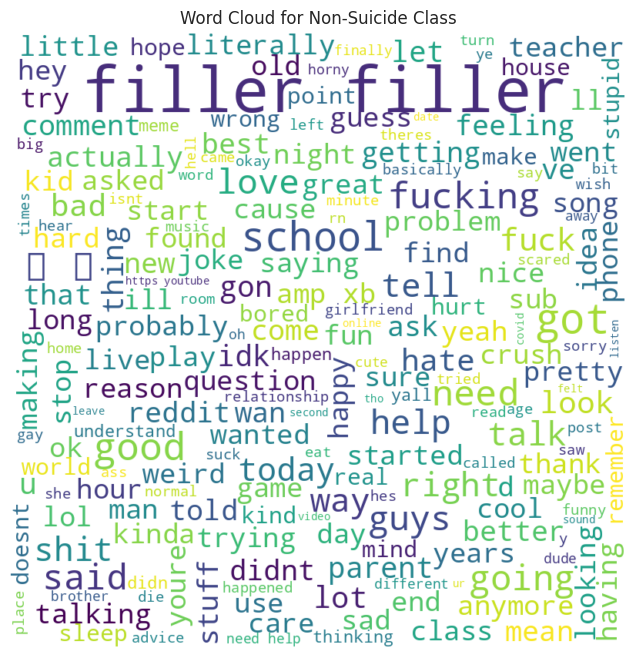

In [103]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Aggregate the cleaned_text for each class
text_sui_1 = " ".join(text for text in data_sui_1_vis['cleaned_text'])
text_sui_0 = " ".join(text for text in data_sui_0_vis['cleaned_text'])

# Define a function to generate and plot a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=set(['is', 'a', 'for', 'and']),
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds
plot_wordcloud(text_sui_1, "Word Cloud for Suicide Class")
print()
print()
plot_wordcloud(text_sui_0, "Word Cloud for Non-Suicide Class")

It's deeply saddening to see the words used by individuals who took their own lives, especially when it appears they went unheard. If there was greater awareness, would we encounter these words as frequently? Would young individuals feel compelled to leave the world behind in this manner?

### **Let's discover some phrases**

**Suicide = True, phrase length = 2**

In [104]:
data_sui_1_vis =  subset_clean[subset_clean['class'] == "suicide"]
data_sui_0_vis =  subset_clean[subset_clean['class'] == "non-suicide"]

In [105]:
data_sui_1_vis

,text,class,cleaned_text,Len
0,I Don't know?7? Months self harm free and the ...,suicide,self harm free urge gets stronger stronger pas...,59
3,I've honestly got no idea what to do anymore.I...,suicide,honestly got idea anymoreit feels fake backtal...,62
9,Wondering what to do with my last one or two w...,suicide,wondering weeksi looking help community posted...,18
10,Feeling very depressed and stressed. Someone w...,suicide,feeling depressed stressed whos actually carin...,20
11,Even though there is no clear answer in lifeAt...,suicide,clear answer lifeat tell wrong,5
...,...,...,...,...
49988,"A hopeless situationI'm fat, ugly, socially wi...",suicide,hopeless situationim fat ugly socially withdra...,36
49989,Can’t seem to get happyMy girlfriend recently ...,suicide,happymy girlfriend recently left wasn looking ...,31
49990,I'm never getting out of hereI've been living ...,suicide,getting hereive living rent subsidized apartme...,34
49992,It’s so hard to cope with being uglyThe feelin...,suicide,hard cope uglythe feeling knowing ll appealing...,45


In [106]:
# Instantiate the TfidfVectorizer with ngram_range set to bigrams
vectorizer = TfidfVectorizer(ngram_range=(2,2))

# Fit and transform your dataset
tfidf_matrix = vectorizer.fit_transform(data_sui_1_vis['cleaned_text'])

# If you want to see the feature names (bigrams in this case)
feature_names = vectorizer.get_feature_names_out()



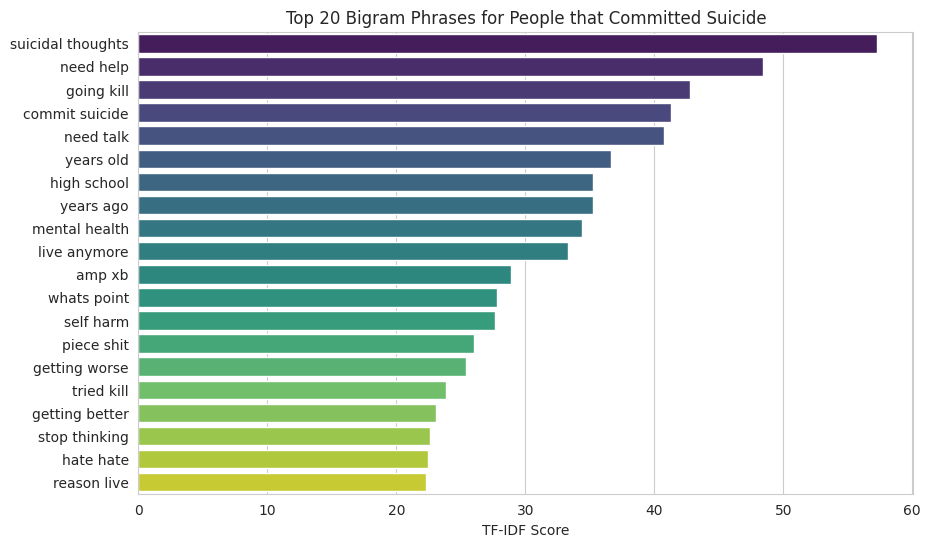

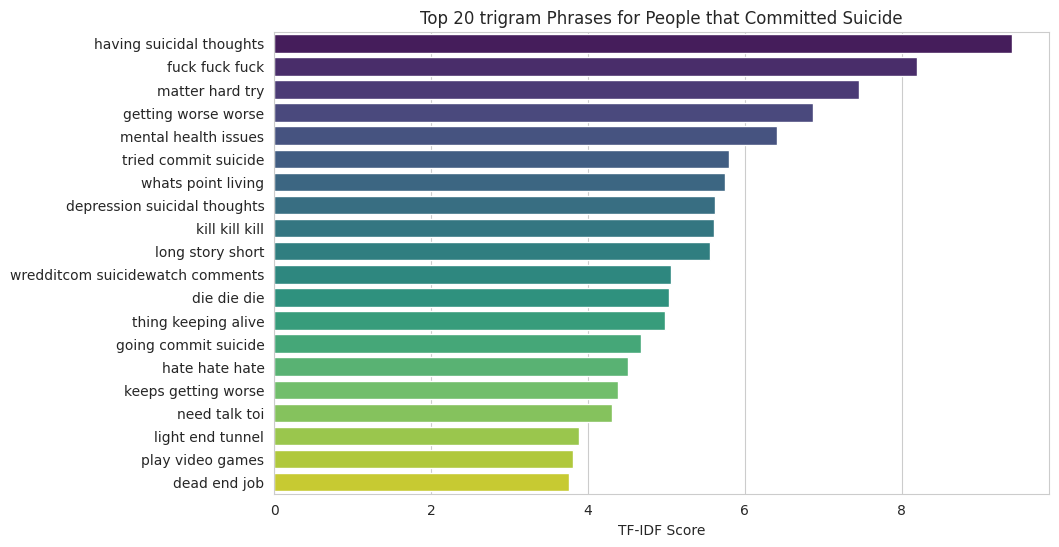

----------------------------------------------------------------------------------------------------


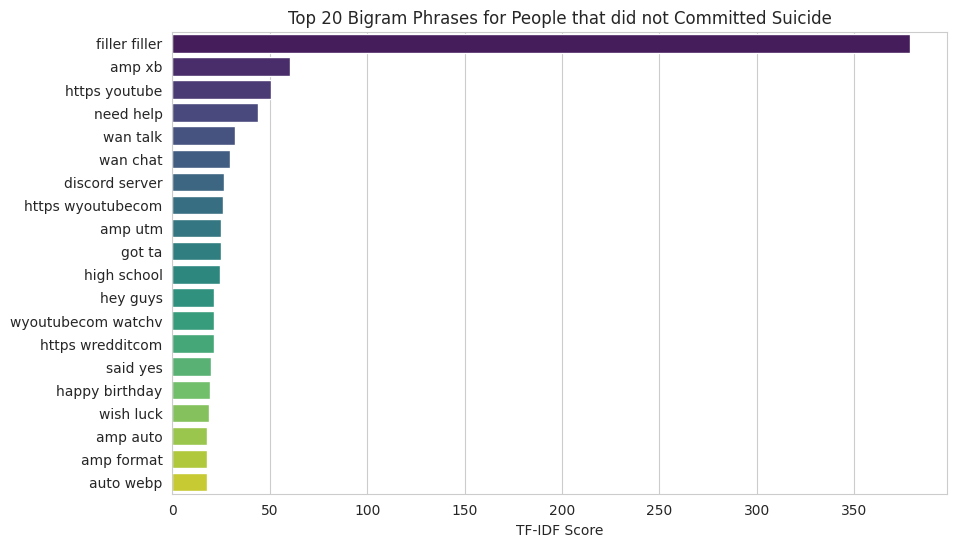

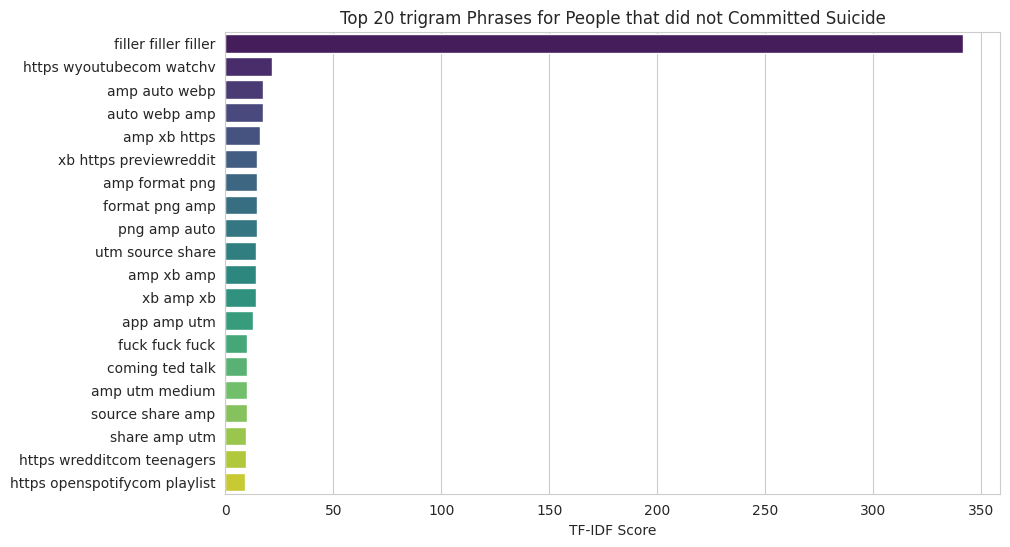

In [107]:
def plot_top_ngrams(dataframe, column, n_gram_range, top_n, title):
    """
    Plots the top N n-grams based on their TF-IDF scores.

    Parameters:
    - dataframe: The input dataframe.
    - column: The column in the dataframe that contains text data.
    - n_gram_range: Tuple of lower and upper boundary of the n-values for n-grams to be extracted.
    - top_n: Number of top n-grams to display.
    - title: Title for the plot.
    """
    # Initialize the vectorizer
    vectorizer = TfidfVectorizer(ngram_range=n_gram_range)

    # Generate the tf-idf matrix
    tfidf_matrix = vectorizer.fit_transform(dataframe[column])

    # Get the feature names
    feature_names = vectorizer.get_feature_names_out()

    # Sum the tf-idf scores for each n-gram across all documents
    sums = tfidf_matrix.sum(axis=0)

    # Create a dictionary of n-gram : score
    data = {}
    for col, term in enumerate(feature_names):
        data[term] = sums[0,col]

    # Sort the dictionary in descending order by score
    sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)

    # Get the top N n-grams and their scores
    top_items = sorted_data[:top_n]
    terms = [item[0] for item in top_items]
    scores = [item[1] for item in top_items]

    # Plotting with seaborn
    plt.figure(figsize=(10,6))
    sns.barplot(x=scores, y=terms, palette="viridis")
    plt.xlabel('TF-IDF Score')
    plt.title(title)
    plt.show()

# Usage example:
plot_top_ngrams(data_sui_1_vis, 'cleaned_text', (2,2), 20, 'Top 20 Bigram Phrases for People that Committed Suicide')
plot_top_ngrams(data_sui_1_vis, 'cleaned_text', (3,3), 20, 'Top 20 trigram Phrases for People that Committed Suicide')
print("-"*100)
plot_top_ngrams(data_sui_0_vis, 'cleaned_text', (2,2), 20, 'Top 20 Bigram Phrases for People that did not Committed Suicide')
plot_top_ngrams(data_sui_0_vis, 'cleaned_text', (3,3), 20, 'Top 20 trigram Phrases for People that did not Committed Suicide')


## 2. **Fine-Tuning a Transformer Model to Detect sentences that indicate someone who has a high chance of committing suicide.**





In [108]:
subset_clean

,text,class,cleaned_text,Len
0,I Don't know?7? Months self harm free and the ...,suicide,self harm free urge gets stronger stronger pas...,59
1,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide,start rich start company afford big van trips ...,11
2,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide,poem haiku u game dev hi hello hello stop fuck...,13
3,I've honestly got no idea what to do anymore.I...,suicide,honestly got idea anymoreit feels fake backtal...,62
4,Do you ever just cry? Like you just think abou...,non-suicide,cry unfair cry cry sit seriously sitting cryin...,12
...,...,...,...,...
49995,okay say whatever you want BUT what is wrong w...,non-suicide,okay wrong rules repost memes subreddit find g...,22
49996,one more stop til school yay,non-suicide,stop til school yay,4
49997,Yo I found an amazing routine. Master of batio...,non-suicide,yo found amazing routine master bation shower ...,12
49998,FUCKKKKK more texts more texts more texts My b...,non-suicide,fuck texts texts texts brother found reddit ac...,16


In [109]:
subset_df_for_model = subset_clean.drop('text', axis=1)
subset_df_for_model = subset_clean[['cleaned_text', 'class']]
subset_df_for_model

,cleaned_text,class
0,self harm free urge gets stronger stronger pas...,suicide
1,start rich start company afford big van trips ...,non-suicide
2,poem haiku u game dev hi hello hello stop fuck...,non-suicide
3,honestly got idea anymoreit feels fake backtal...,suicide
4,cry unfair cry cry sit seriously sitting cryin...,non-suicide
...,...,...
49995,okay wrong rules repost memes subreddit find g...,non-suicide
49996,stop til school yay,non-suicide
49997,yo found amazing routine master bation shower ...,non-suicide
49998,fuck texts texts texts brother found reddit ac...,non-suicide


**Convert the labels to numerial type**

In [110]:
subset_df_for_model['class'] = subset_df_for_model['class'].apply(lambda x: 1 if x == 'suicide' else 0)

<ipython-input-110-c124806ce34b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df_for_model['class'] = subset_df_for_model['class'].apply(lambda x: 1 if x == 'suicide' else 0)


In [111]:
subset_df_for_model

,cleaned_text,class
0,self harm free urge gets stronger stronger pas...,1
1,start rich start company afford big van trips ...,0
2,poem haiku u game dev hi hello hello stop fuck...,0
3,honestly got idea anymoreit feels fake backtal...,1
4,cry unfair cry cry sit seriously sitting cryin...,0
...,...,...
49995,okay wrong rules repost memes subreddit find g...,0
49996,stop til school yay,0
49997,yo found amazing routine master bation shower ...,0
49998,fuck texts texts texts brother found reddit ac...,0


**splitting our subset data to train and validation sets.**

In [112]:
train_data, val_data = train_test_split(subset_df_for_model,test_size=0.15, random_state=42)

train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)

val_data = val_data.reset_index()
val_data = val_data.drop('index', axis=1)

In [113]:
train_data

,cleaned_text,class
0,tips write script review game wan video bored ...,0
1,came said wrong sexuality panic,0
2,question hate kardashians genuinely curious,0
3,preferring thick thighs muscle fat filler fill...,0
4,fuck ll lost game,0
...,...,...
38639,yall female teacher whos hella horny popular g...,0
38640,okay math gt english english gt bio chem physi...,0
38641,soon fucking matters long story short csn moni...,1
38642,read struggling school haven able learn regent...,0


In [114]:
val_data

,cleaned_text,class
0,love reddit barley couple hours makin memes ph...,0
1,youre gon sex jokes turn user flair arent pedo,0
2,endmy lifes shit years getting surgery upcomin...,1
3,final stretchi hate job hell lost days passed ...,1
4,fuck examsjust got final marks uni courses d i...,1
...,...,...
6815,gon fucking pillschange mind actually pretty s...,1
6816,english speaking looking play ve downloaded tr...,0
6817,got zoned starting talking literally second st...,0
6818,code requesting immediate backup dispatch copy...,0


In [137]:
train_data['class'].value_counts()

0    20703
1    17941
Name: class, dtype: int64

**Converting our datasets to Hugging Face datasets**

In [115]:
from datasets import Dataset

hf_dataset_train = Dataset.from_pandas(train_data)
hf_dataset_val = Dataset.from_pandas(val_data)

**Loading and tokenizing our texts**

In [116]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [117]:
def tokenize_function(hf_dataset):
    return tokenizer(list(hf_dataset['cleaned_text']), truncation=True)

In [118]:
tokenized_dataset_train = hf_dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_val = hf_dataset_val.map(tokenize_function, batched=True)

Map:   0%|          | 0/38644 [00:00<?, ? examples/s]

Map:   0%|          | 0/6820 [00:00<?, ? examples/s]

In [119]:
tokenized_dataset_train

Dataset({
    features: ['cleaned_text', 'class', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 38644
})

In [120]:
tokenized_dataset_val

Dataset({
    features: ['cleaned_text', 'class', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6820
})

In [121]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

**Creating the datasets for the find tuning**

In [122]:
tf_train_dataset = tokenized_dataset_train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["class"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["class"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [123]:
tf_validation_dataset

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

**Loading the pre trained model**

In [124]:
from transformers import TFBertForSequenceClassification, BertConfig
from tensorflow.keras.layers import Dense
from transformers import BertConfig

config = BertConfig.from_pretrained('bert-base-uncased')
config.num_labels = 1  # the number of output labels to 1

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.classifier = Dense(1, activation='sigmoid')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Using keras API to fine tune**

In [125]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


optimizer = Adam(learning_rate=3e-5)

model.compile(
    optimizer=optimizer,
    loss=BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=2,
    batch_size = 32,
    verbose = 1
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4831/4831 [==============================] - 434s 81ms/step - loss: 0.1169 - accuracy: 0.9578 - val_loss: 0.0887 - val_accuracy: 0.9716
Epoch 2/2
4831/4831 [==============================] - 318s 66ms/step - loss: 0.0578 - accuracy: 0.9802 - val_loss: 0.0981 - val_accuracy: 0.9754


The model underwent fine-tuning for 2 epochs. In the first epoch, it achieved a training accuracy of 95.78% with a loss of 0.1169, and on the validation set, it achieved an accuracy of 97.16% with a loss of 0.0887. By the second epoch, the training accuracy improved to 98.02% with a reduced loss of 0.0578, while the validation accuracy rose slightly to 97.54% with a corresponding loss of 0.0981.


After fine-tuning the BERT model for 2 epochs, we observed significant improvements in its performance. The training accuracy started at 95.78% and increased to 98.02% by the second epoch. Simultaneously, the validation accuracy reached an impressive 97.54%. However, it's notable that the validation loss increased slightly in the second epoch, from 0.0887 to 0.0981, which may suggest the early signs of overfitting. Overall, the results indicate a well-performing model, but continuous monitoring for overfitting is recommended in subsequent epochs.

In [141]:
test_text = "i want to die, i can't with this life anymore" # Suicide
test_text = process_text(test_text)
print(test_text)
# Tokenize the test_text
inputs = tokenizer(test_text, return_tensors='tf', truncation=True)
print(inputs)
# Get model predictions
predictions = model.predict([inputs['input_ids'], inputs['attention_mask']])[0]
# Assuming the output is a single scalar value after the sigmoid activation:
predicted_label = 1 if predictions[0] >= 0.5 else 0

print(predicted_label)

die anymore
{'input_ids': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[ 101, 3280, 4902,  102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[1, 1, 1, 1]], dtype=int32)>}
1/1 [==============================] - 0s 43ms/step
1


## **3. Saving the Model For Future Improvement**


Storing our trained model is an essential step in the machine learning pipeline. It allows us to pick up from where we left off, avoiding the computational cost and time of retraining from scratch. As our model may not yet be ready for real-world scenarios, having a saved version ensures that we can continually refine, test, and iterate upon its current capabilities for optimal performance in future enhancements.

In [146]:
base_path = "/content/drive/MyDrive/data scienece AI/PROJECTS/SUICIDE ANALYSIS AND PREDECTION/"
tokenizer_save_path = base_path + "tokenizer"
model_save_path = base_path + "model"


tokenizer.save_pretrained(tokenizer_save_path) # saving the tokenizer
model.save_pretrained(model_save_path) # saving the model

In [ ]:
loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path)  # loading the tokenizer
loaded_model = TFBertForSequenceClassification.from_pretrained(model_save_path) # loading the model

In [153]:
import pickle


history_path = base_path + "training_history.pkl" # saving the model performance

# Save the history object
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

In [155]:
# Load the history object
with open(history_path, 'rb') as file:
    loaded_history = pickle.load(file)
loaded_history

{'loss': [0.11686597019433975, 0.05780640244483948],
 'accuracy': [0.9578459858894348, 0.9801780581474304],
 'val_loss': [0.08867262303829193, 0.09807281941175461],
 'val_accuracy': [0.9715542793273926, 0.9753665924072266]}